# Instrument Recognizer V1

### *Configuration Class for convenience to utilize run-all operations*

In [5]:
class Config:
    # Specify whether to load the dataset directly or save it to local storage or Google Drive
    LOAD_DATASET_TRAIN = True # True = local, false = colab
    LOAD_DATASET_TEST = True # True = local, false = colab
    LOCAL_DATASET_PATH = "/content/Irmas_TestData"
    GOOGLE_DRIVE_DATASET_PATH = "/content/drive/MyDrive/dataset/IRMAS_dataset"
    #PLEASE SET BEFORE RUN-ALL:
    dataset_folder = LOCAL_DATASET_PATH

## Get Dataset
Going to start with the IRMAS dataset with potential intentions to move to Google's NSynth dataset.

In [2]:
if Config.dataset_folder == Config.GOOGLE_DRIVE_DATASET_PATH:
  from google.colab import drive
  drive.mount('/content/drive')

## Install Dependencies

In [24]:
!pip install wget

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import wget
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## Download Training Data
Set the configuration at the top of the page

In [6]:
if(Config.LOAD_DATASET_TRAIN):
  dataset_folder = Config.dataset_folder

  # Ensure all parent directories exist
  os.makedirs(os.path.dirname(dataset_folder), exist_ok=True)

  # Now create the target directory
  if not os.path.exists(dataset_folder):
      os.makedirs(dataset_folder)

  # URL to download the dataset
  url = 'https://zenodo.org/record/1290750/files/IRMAS-TrainingData.zip'

  # Path where you want to save the dataset
  dataset_zip_path = os.path.join(dataset_folder, 'IRMAS-TrainingData.zip')

  # Download the dataset
  wget.download(url, dataset_zip_path)

  # Unzip the dataset
  with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
      zip_ref.extractall(dataset_folder)

  # Remove the zip file after extraction
  os.remove(dataset_zip_path)


## Download Test Data
Currently, the provided test set is in a completely different format from the training set. Would make more sense for subsequent builds to split a test set off from the training set at the very beginning.

In [7]:
if(Config.LOAD_DATASET_TEST):
  # URL to download the test dataset
  test_dataset_url = 'https://zenodo.org/record/1290750/files/IRMAS-TestingData-Part1.zip'

  # Path to save the downloaded zip file
  test_dataset_zip_path = os.path.join("Irmas_TestData", 'IRMAS-TestingData-Part1.zip')

  # Create the directory if it doesn't exist
  os.makedirs("Irmas_TestData", exist_ok=True)

  # Download the test dataset
  wget.download(test_dataset_url, test_dataset_zip_path)

  # Unzip the test dataset
  with zipfile.ZipFile(test_dataset_zip_path, 'r') as zip_ref:
      zip_ref.extractall("Irmas_TestData")

  # Remove the zip file after extraction
  os.remove(test_dataset_zip_path)

  # Verify if the test dataset folder is created
  test_dataset_folder = os.path.join("Irmas_TestData", 'IRMAS-TestingData-Part1')
  if os.path.exists(test_dataset_folder):
      print("Test dataset directory created successfully!")
  else:
      print("Error creating test dataset directory.")

Test dataset directory created successfully!


In [64]:
import random

# do not use
def time_stretch(audio_data, rate=0.8, target_length=None):
    stretched_audio = librosa.effects.time_stretch(audio_data, rate=rate)
    
    if target_length is not None:
        current_length = len(stretched_audio)
        
        if current_length > target_length:
            stretched_audio = stretched_audio[:target_length]
        elif current_length < target_length:
            padding = target_length - current_length
            stretched_audio = np.pad(stretched_audio, (0, padding), 'constant')

    return stretched_audio

def pitch_shift(audio_data, sr, n_steps=5):
    return librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=n_steps)

def add_noise(audio_data, noise_level=0.005):
    # Check if audio_data is mono or stereo
    if audio_data.ndim == 1:
        noise = np.random.randn(len(audio_data))
    else:
        noise = np.random.randn(*audio_data.shape)
        
    augmented_audio_data = audio_data + noise_level * noise
    assert len(audio_data) == len(augmented_audio_data)
    return augmented_audio_data

def reverse_channels(audio_data):
    if audio_data.shape[0] == 2:
        return audio_data[::-1, :]
    else:
        return audio_data

def augment_audio(audio_data, sr):
    augmentations = [
                    lambda x: add_noise(x),
                    lambda x: reverse_channels(audio_data),
                    lambda x: pitch_shift(x, sr=sr, n_steps=random.randint(-5, 5))
                    ]
    
    # Choose a random augmentation
    aug_func = random.choice(augmentations)
    return aug_func(audio_data)

In [65]:
class IRMASDataset:
    def __init__(self, dataset_folder):
        self.dataset_folder = dataset_folder
        self.classes = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']

    def load_train_data(self, augment=False):
        X_train = []
        y_train = []

        train_folder = os.path.join(self.dataset_folder, 'IRMAS-TrainingData')

        for root, dirs, files in os.walk(train_folder):
            for file in files:
                if file.endswith('.wav'):
                    # Load audio file
                    filepath = os.path.join(root, file)
                    audio_data, sr = librosa.load(filepath, sr=None, mono=False)

                    # Extract class label
                    label = os.path.basename(root)
                    class_id = self.classes.index(label)

                    X_train.append(audio_data)
                    y_train.append(class_id)

                    # Data augmentation
                    if augment:
                        audio_data = augment_audio(audio_data, sr)
                        X_train.append(audio_data)
                        y_train.append(class_id)
                    
        return np.array(X_train), np.array(y_train)

    #TODO: This function needs rewritten to account for multilabels as well as label format in text
    def load_test_data(self):
        X_test = []
        y_test = []

        test_folder = os.path.join("Irmas_TestData", 'IRMAS-TestingData-Part1')

        for root, dirs, files in os.walk(test_folder):
            for file in files:
                if file.endswith('.wav'):
                    # Load audio file
                    filepath = os.path.join(root, file)
                    audio_data, _ = librosa.load(filepath, sr=None)

                    # Extract class label
                    label = os.path.basename(root)
                    class_id = self.classes.index(label)

                    X_test.append(audio_data)
                    y_test.append(class_id)

        return np.array(X_test), np.array(y_test)

irmas_dataset = IRMASDataset(dataset_folder)


In [66]:
X_train, y_train = irmas_dataset.load_train_data(augment=True)
print("Training and test data loaded successfully!")

Training and test data loaded successfully!


In [10]:
X_train, y_train

(array([[-7.9345703e-04, -5.0354004e-04, -1.9836426e-04, ...,
         -3.6773682e-03, -3.6926270e-03, -3.6773682e-03],
        [ 1.1596680e-03,  9.6130371e-04,  8.0871582e-04, ...,
         -4.3487549e-03, -2.4566650e-03, -1.0681152e-03],
        [-8.3923340e-03, -7.9040527e-03, -7.5683594e-03, ...,
          2.7236938e-02,  2.4841309e-02,  2.1942139e-02],
        ...,
        [ 9.4604492e-03, -8.2397461e-03, -2.2598267e-02, ...,
          2.9602051e-02,  3.3691406e-02,  4.4311523e-02],
        [ 5.5130005e-02,  4.5211792e-02,  3.5598755e-02, ...,
          1.8013000e-01,  2.9525757e-01,  8.5250854e-02],
        [ 6.9412231e-02,  5.0262451e-02,  5.6564331e-02, ...,
          1.4939880e-01,  1.7156982e-01,  1.9276428e-01]], dtype=float32),
 array([ 0,  0,  0, ..., 10, 10, 10]))

In [67]:
X_train.shape, y_train.shape

((13410, 2, 132299), (13410,))

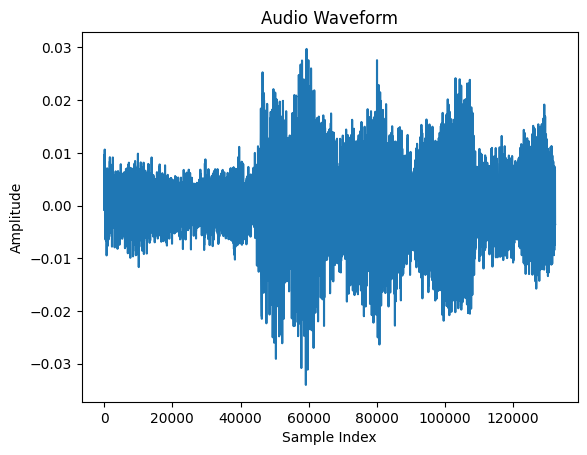

In [12]:
# Plot the first audio waveform
plt.plot(X_train[0])
plt.title('Audio Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

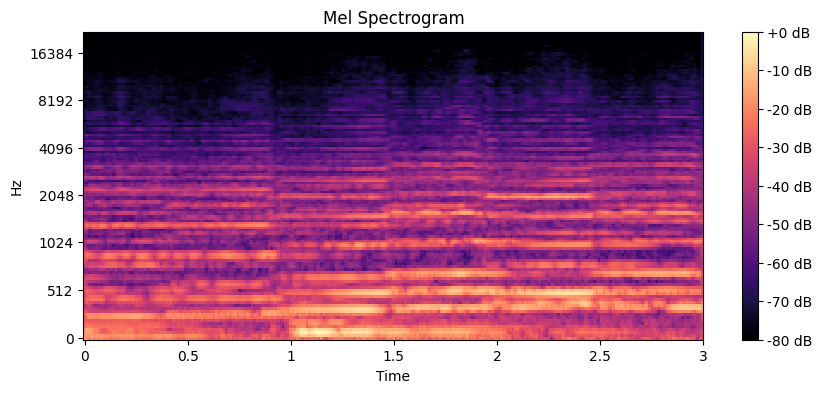

In [13]:
# Select an audio sample from X_train
audio_data = X_train[0]  # Assuming you want to process the first audio sample

# Assuming the sampling rate is known (you can replace it with the actual sampling rate if available)
sr = 44100  # Replace with the actual sampling rate if available

# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr)

# Convert to decibels (log scale)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

In [68]:
def compute_spectrogram(audio_data, sr=44100):
    # Compute the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr)

    # Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    return spectrogram_db

# Convert all audio samples in X_train to spectrograms
X_train_spectrograms = []
for audio_data in X_train:
    spectrogram = compute_spectrogram(audio_data)
    X_train_spectrograms.append(spectrogram)

# Convert the list of spectrograms to a NumPy array
X_train_spectrograms = np.array(X_train_spectrograms)

# Verify the shape of the array
print("Shape of X_train_spectrograms:", X_train_spectrograms.shape)

Shape of X_train_spectrograms: (13410, 2, 128, 259)


In [69]:
# Calculate mean and standard deviation of the spectrogram data
mean = np.mean(X_train_spectrograms)
std = np.std(X_train_spectrograms)

# Normalize the spectrogram data using mean and standard deviation
X_train_spectrograms_normalized = (X_train_spectrograms - mean) / std
X_train_spectrograms_normalized.shape

(13410, 2, 128, 259)

In [75]:
# X_train_spectrograms_normalized and y_train are properly defined

# Convert integer labels to one-hot encoded vectors
num_classes = 11
y_train_one_hot = to_categorical(y_train, num_classes)

# Define the CNN model
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(rate=0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Define input shape based on spectrogram dimensions
X_train_spectrograms_normalized = np.transpose(X_train_spectrograms_normalized, (0, 2, 3, 1)) # transpose if we're using stereo audio
input_shape = X_train_spectrograms_normalized.shape[1:]# + (1,)

# Create the CNN model
model = create_cnn_model(input_shape)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model_2.keras",
        save_bast_only=True,
        monitor="val_loss"
    )
]

# Train-test split
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_train_spectrograms_normalized, y_train_one_hot, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train_f, y_train_f, epochs=10, validation_data=(X_val_f, y_val_f), callbacks=callbacks)

Epoch 1/10
336/336 [==============================] - 288s 845ms/step - loss: 2.0551 - accuracy: 0.3015 - val_loss: 1.7640 - val_accuracy: 0.4191
Epoch 2/10
336/336 [==============================] - 276s 821ms/step - loss: 1.6697 - accuracy: 0.4492 - val_loss: 1.6101 - val_accuracy: 0.4627
Epoch 3/10
336/336 [==============================] - 264s 785ms/step - loss: 1.3933 - accuracy: 0.5365 - val_loss: 1.3118 - val_accuracy: 0.5697
Epoch 4/10
336/336 [==============================] - 270s 803ms/step - loss: 1.1142 - accuracy: 0.6287 - val_loss: 1.1928 - val_accuracy: 0.5992
Epoch 5/10
336/336 [==============================] - 269s 802ms/step - loss: 0.8666 - accuracy: 0.7072 - val_loss: 1.0186 - val_accuracy: 0.6700
Epoch 6/10
336/336 [==============================] - 270s 804ms/step - loss: 0.6436 - accuracy: 0.7871 - val_loss: 0.9477 - val_accuracy: 0.7073
Epoch 7/10
336/336 [==============================] - 258s 767ms/step - loss: 0.4900 - accuracy: 0.8390 - val_loss: 0.9275 -

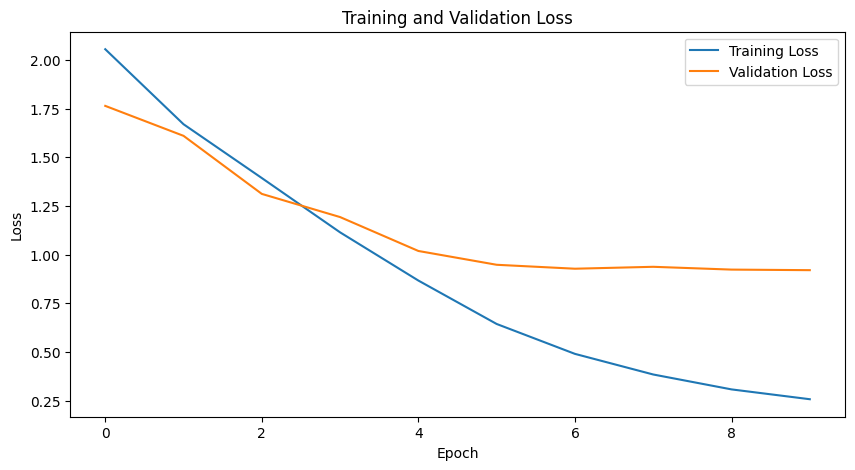

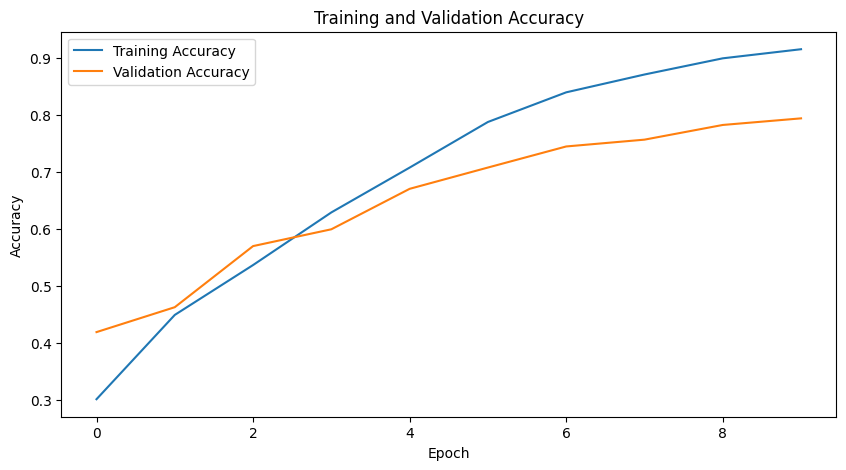

In [76]:
# Extract loss and accuracy from history
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [77]:
# Function to extract features from audio files
def extract_features(file_path, mfcc=True, chroma=True, mel=True):
    with open(file_path, 'rb') as file:
        audio, sample_rate = librosa.load(file, sr=None)
        features = []
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
            features.extend(mfccs)
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T,axis=0)
            features.extend(chroma)
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T,axis=0)
            features.extend(mel)
    return features

# Directory containing the audio files
test_dataset_folder = "Irmas_TestData/IRMAS-TestingData-Part1/"

# Initialize empty lists to store features and labels
test_data = []
labels = []

# Iterate through each audio file in the directory
for root, dirs, files in os.walk(test_dataset_folder):
    for file in files:
        if file.endswith(".wav"):  # assuming audio files are in .wav format
            file_path = os.path.join(root, file)
            label = os.path.basename(root)  # assuming each subfolder corresponds to a class
            features = extract_features(file_path)
            test_data.append(features)
            labels.append(label)

# Convert lists to numpy arrays
test_data = np.array(test_data)
labels = np.array(labels)

# Display the shape of the test data array
print("Test data array shape:", test_data.shape)
print("Labels array shape:", labels.shape)


KeyboardInterrupt: 

## TODO: Get the provided test data in a usable state, or alternatively section off a test set from the start.

In [9]:
test_model = keras.models.load_model("best_model_1.keras")
test_loss, test_acc = test_model.evaluate(test_data, labels)

# Playing around with some of the samples and making predictions:

In [60]:
test_model = keras.models.load_model("best_model_1.keras")

In [63]:
trial_audio_data, _ = librosa.load("/content/Irmas_TestData/IRMAS-TestingData-Part1/Part1/01) Bert Jansch - Avocet-48.wav", sr=None)
trial_spectrogram = compute_spectrogram(trial_audio_data[:132299], 44100)
trial_spectrogram = (trial_spectrogram - mean) / std
trial_spectrogram = np.expand_dims(trial_spectrogram, axis=-1)
trial_spectrogram = trial_spectrogram.reshape(-1, 128, 259, 1)
trial_spectrogram.shape

(1, 128, 259, 1)

In [64]:
prediction = test_model.predict(trial_spectrogram)
index = np.argmax(prediction)
irmas_dataset.classes[index]

1/1 [==============================] - 0s 38ms/step


'gac'

Convert .keras model to .h5 format

In [3]:
INPUT_NAME = "best_model_2.keras"
OUTPUT_NAME = "model_3_23_24.h5"

model = keras.models.load_model(INPUT_NAME)
model.save(OUTPUT_NAME)